In [1]:
import dash
from dash import dash_table
from dash import html
from dash import dcc
import plotly.graph_objects as go
import plotly.express as px
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bisect import bisect_left, bisect_right
from jupyter_dash import JupyterDash
import dash_bootstrap_components as dbc
#from dash.dependencies import Input, Output
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import copy
import CropNBalFunctions as cnbf
import CropNBalUICompenents as uic
#from dash_extensions.enrich import Output, DashProxy, Input, MultiplexerTransform
from dash.exceptions import PreventUpdate
import os
from dash import Dash, dcc, html, Input, Output, State, MATCH, ALL

## General components

In [2]:
CropCoefficients, EndUseCatagoriesDropdown, metFiles, MetDropDown, MonthIndexs = uic.Generalcomponents()

## Core crop model components

Text(0.5, 0, 'Temperature accumulation')

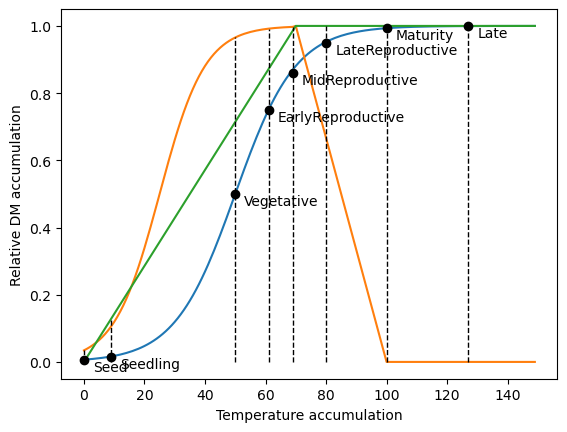

In [3]:
Scallers = cnbf.Scallers 
StagePropns = cnbf.StagePropns

# Graphs scallers over thermal time series
Graph = plt.figure()
plt.plot(Scallers.loc[:,'scaller'])
plt.plot(Scallers.loc[:,'cover'])
plt.plot(Scallers.loc[:,'rootDepth'])
T_mat = 100
for p in StagePropns.index:
    plt.plot(StagePropns.loc[p,'PrpnTt']*T_mat,StagePropns.loc[p,'PrpnMaxDM'],'o',color='k')
    plt.text(StagePropns.loc[p,'PrpnTt']*T_mat+3,StagePropns.loc[p,'PrpnMaxDM'],p,verticalalignment='top')
    plt.plot([StagePropns.loc[p,'PrpnTt']*T_mat]*2,[0,Scallers.loc[round(StagePropns.loc[p,'PrpnTt'] * T_mat),'max']],'--',color='k',lw=1)
plt.ylabel('Relative DM accumulation')
plt.xlabel('Temperature accumulation')


## Graph constructors

In [4]:
def AddTimeLines(fig,ypos,start):
    weighting = [.99,.5,.05]
    align = ['left','center','right']
    pos = 0
    for p in uic.Positions:
        c = pd.read_pickle(p+'Config.pkl')
        fig.add_trace(go.Scatter(x=[c['EstablishDate']]*2,y=[0,ypos*1.1],line = {'color':'grey','dash':'dash'},mode='lines',showlegend=False))
        fig.add_trace(go.Scatter(x=[c['HarvestDate']]*2,y=[0,ypos*1.1],line = {'color':'grey','dash':'dash'},mode='lines',showlegend=False))
        if pos != 0:
            fig.add_annotation(dict(ax= c['HarvestDate'], y= ypos, xref="x", yref="y",text="",showarrow=True,
                                x= c['EstablishDate'], ay= ypos, axref = "x", ayref='y', arrowhead = 3, arrowwidth=1.5, arrowcolor='grey',))
            fig.add_annotation(dict(x= c['HarvestDate'], y= ypos, xref="x", yref="y",text="",showarrow=True,
                                ax= c['EstablishDate'], ay= ypos, axref = "x", ayref='y', arrowhead = 3, arrowwidth=1.5, arrowcolor='grey',))
        else:
            fig.add_annotation(dict(ax= start, y= ypos, xref="x", yref="y",text="",showarrow=True,
                                x= c['HarvestDate'], ay= ypos, axref = "x", ayref='y', arrowhead = 3, arrowwidth=1.5, arrowcolor='grey',))
            
        middate = c['EstablishDate'].astype(dt.datetime) + (c['HarvestDate'].astype(dt.datetime)-c['EstablishDate'].astype(dt.datetime))*weighting[pos]
        fig.add_trace(go.Scatter(x=[middate], y = [ypos], text = p[:-1] + ' Crop <br>'+ c['Crop'], mode="lines+text",showlegend=False,textposition='middle '+align[pos]))
        pos +=1
    return fig

def CropNGraph(NBalance,start,end):
    cols = ['brown','orange','red','blue','green']
    fig = go.Figure()
    hdates = []
    pdates = []
    for c in uic.Positions:
        config = pd.read_pickle(c+"Config.pkl")
        hdates.append(config['HarvestDate'])
        pdates.append(config['HarvestDate'].astype(dt.datetime)+dt.timedelta(days=7))
    base = [0,0,0]
    pos=0
    for c in ['Root','Stover','FieldLoss','DressingLoss','SaleableProduct']:
        data = NBalance.loc[hdates,c]
        fig.add_trace(go.Bar(x =  pdates, y = data, base = base, offsetgroup=0, name=c, text=c,width=86400000*14,marker={'color':cols[pos]}))
        base = np.add(base,data)
        pos+=1
    data = [0]* len(NBalance.index)
    for c in ['Root','Stover','FieldLoss','DressingLoss','SaleableProduct']:
        data = np.add(data,NBalance.loc[:,c])
    data = data.where(data > 0, np.nan)
    fig.add_trace(go.Scatter(x=NBalance.index,y=data,name='Crop N',line = {'color':'green',},connectgaps=False))
    ypos = data.max()*1.1
    for p in ['P','C']:
        colpos = 0
        data = [0] * len(NBalance.index)
        for r in ['resRoot', 'resStover', 'resFeildLoss']:
            data = np.add(data,NBalance.loc[:,p+r])
            fig.add_trace(go.Scatter(x=NBalance.index+ dt.timedelta(days=14),y=data.where(data > 0.1, np.nan),name=r,line = {'color':cols[colpos],'dash':'dot'},connectgaps=False,showlegend=False))
            colpos+=1
    fig = AddTimeLines(fig,ypos,start)
    fig.update_layout(title_text="Crop N", title_font_size = 30, title_x = 0.5, title_xanchor = 'center')
    fig.update_yaxes(title_text="Nitrogen (kg/ha)", title_font_size = 20, range=[0,ypos*1.1])
    fig.update_xaxes(title_text=None,range= [start,end])
    fig.update_layout(legend_traceorder="reversed")
    return fig

def CropWaterGraph(cropWater):
    NData = cropWater.reset_index()
    fig = px.line(data_frame=NData,x='Date',y='Values',color='Component',color_discrete_sequence=['brown','orange','red','green'],
                 )#range_x = [c['EstablishDate']-dt.timedelta(days=7),c['HarvestDate']+dt.timedelta(days=7)])
    fig.update_layout(title_text="Cover and Root Depth", title_font_size = 30, title_x = 0.5, title_xanchor = 'center')
    fig.update_yaxes(title_text="Cover (m2/m2) and depth (m)", title_font_size = 20)
    fig.update_xaxes(title_text=None)
    return fig

def NInputsGraph(NBalance,start,end):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=NBalance.index,y=NBalance.loc[:,'SOMNmineraliation'].cumsum(),name='SOM mineralisation',line = {'color':'black'},connectgaps=False))
    fig.add_trace(go.Scatter(x=NBalance.index,y=NBalance.loc[:,'ResidueMineralisation'].cumsum(),name='Residues mineralisation',line = {'color':'orange'},connectgaps=False))
    ypos = NBalance.loc[:,['SOMNmineraliation','ResidueMineralisation']].cumsum().max().max()
    fig = AddTimeLines(fig,ypos,start)
    fig.update_layout(title_text="N Inputs", title_font_size = 30, title_x = 0.5, title_xanchor = 'center')
    fig.update_yaxes(title_text="Nitrogen (kg/ha)", title_font_size = 20,range=[0,ypos*1.1])
    fig.update_xaxes(title_text=None,range=[start,end])
    
    return fig

def SoilNGraph(NBalance,start,end,trigger,Fertiliser):
    CurrentConfig = pd.read_pickle("Current_Config.pkl")
    FieldConfig = pd.read_pickle("Field_Config.pkl")
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=[FieldConfig['MinNDate']], y=[FieldConfig['MinN']], mode="markers", name='Measured Soil N',line = {'color':'darkblue'}, marker_symbol = 'x',marker_size=15))
    fig.add_trace(go.Scatter(x=NBalance.index,y=NBalance.loc[:,'SoilMineralN'],name='Estimated Soil N',line = {'color':'brown'},connectgaps=False))
    ypos = NBalance.loc[:,'SoilMineralN'].max()*1.3
    fig = AddTimeLines(fig,ypos,start)
    runningmeanCU = []
    last7days = []
    for u in NBalance.CropUptake:
        if len(last7days) >= 14:
            del last7days[0]
        last7days.append(u)
        runningmeanCU.append(np.mean(last7days)*10)
    fig.add_trace(go.Scatter(x=[CurrentConfig['EstablishDate'],CurrentConfig['HarvestDate'],end],y=[trigger]*2,name='Fertiliser Trigger',line = {'color':'magenta'}, mode="lines",connectgaps=False))
    eN = CurrentConfig['EstablishN'] 
    if eN>0:
        edate = CurrentConfig['EstablishDate'] 
        dbfedate = (edate.astype(dt.datetime) - dt.timedelta(days=1)).strftime('%Y-%m-%d')
        fig.add_trace(go.Bar(x = [edate], y = [eN], base = NBalance.loc[dbfedate,'SoilMineralN'],
                             width=86400000*3, name = 'Planting N',marker={'color':'purple'}))
    for f in Fertiliser.index:
        n = f.strftime('%d-%b') + ' ' + str(int(Fertiliser[f])) + ' kg/ha'
        fig.add_trace(go.Bar(x =  [f], y = [Fertiliser[f]], base = trigger ,width=86400000*3, name = n,marker={'color':'crimson'}))
    fig.update_xaxes(range= [start,end],title_text=None)
    fig.update_yaxes(title_text="Nitrogen (kg/ha)", title_font_size = 20,range = [0,ypos*1.1])
    fig.update_layout(title_text="SoilN", title_font_size = 30, title_x = 0.5, title_xanchor = 'center')
    
    return fig

In [5]:
# test = CurrentConfig['EstablishDate'].astype(dt.datetime) - dt.timedelta(days=1)

In [6]:
# test.strftime('%Y-%m-%d')

In [7]:
# NBalance.loc[test.strftime('%Y-%m-%d'),'SoilMineralN']

In [8]:
# CropNGraph(NBalance,start,end)

In [9]:
# SoilNGraph(NBalance,start,end,30,Fertiliser)

In [10]:
# NInputsGraph(NBalance,start,end)

In [11]:
# runningmeanCU = []
# last7days = []
# for u in NBalance.CropUptake:
#     # if len(last7days) >= 14:
#         del last7days[0]
#     last7days.append(u)
#     runningmeanCU.append(np.mean(last7days))

In [12]:
# PreviousConfig = pd.read_pickle("Previous_Config.pkl")
# CurrentConfig = pd.read_pickle("Current_Config.pkl")
# FollowingConfig = pd.read_pickle("Following_Config.pkl")
# FieldConfig = pd.read_pickle("Field_Config.pkl")
# Tt = CalculateMedianTt(PreviousConfig["EstablishDate"].astype(dt.datetime),FollowingConfig["HarvestDate"].astype(dt.datetime),metFiles[FieldConfig["Location"]])
# NBalance = MakeNBalanceFrame(Tt.index)
# NBalance = CalculateCropOutputs(Tt,CropCoefficients,NBalance)
# NBalance = CalculateSOMMineralisation(Tt, NBalance)
# NBalance = CalculateResidueMineralisation(Tt,NBalance)
# NBalance = CalculateSoilMineralN(NBalance)
# NBalance = CalculateFertiliserApplications(NBalance,30,0.8,3)
# Fertiliser = NBalance.FertiliserN.where(NBalance.FertiliserN>0,np.nan).dropna()
# start = PreviousConfig['HarvestDate'].astype(dt.datetime)-dt.timedelta(30)
# end = FollowingConfig['HarvestDate'].astype(dt.datetime)+dt.timedelta(30)

In [13]:
ConfigFiles = []
mydir = 'C:\GitHubRepos\SVS'
for File in os.listdir(mydir):
    if File.endswith('.pkl'):
        if ('_SavedConfig' in File):
            ConfigFiles.append(File.replace('_SavedConfig.pkl',''))

In [14]:
def MakeNBalanceFrame(index):
    columns = ['Root', 'Stover', 'FieldLoss', 'DressingLoss','SaleableProduct', 'TotalCrop', 'Cover','RootDepth', 'SOMNmineraliation', 'PresRoot', 'PresStover', 'PresFeildLoss', 'CresRoot', 'CresStover', 'CresFeildLoss', 'ResidueMineralisation', 'LeachingLoss', 'GasiousLoss', 'SoilMineralN','UnMeasuredSoilN','FertiliserN']
    return pd.DataFrame(index = index, columns = columns, data= 0.0)

In [15]:
#Empty arrays to hold example data
BiomassScaller = []
CoverScaller = []
RootDepthScaller = []
#Example parameters
Xo_Biomass = 50
b_Biomass = Xo_Biomass*0.2
A_cov = 1
T_mat = Xo_Biomass*2
T_sen = T_mat-30
Xo_cov = T_mat * 0.25
b_cov = Xo_cov * 0.3
#Example thermal time series
Tts = range(150)
#Calculate biomass, cover and root depth callers at each Tt in the series
for tt in Tts:
    BiomassScaller.append(1/(1+np.exp(-((tt-Xo_Biomass)/(b_Biomass)))))
    cover = 0
    if tt < T_sen:
        cover = A_cov * 1/(1+np.exp(-((tt-Xo_cov)/b_cov)))
        rd = tt/T_sen
    else:
        if tt < T_mat:
            cover = A_cov * (1-(tt-T_sen)/(T_mat-T_sen))
            rd = 1.0
    CoverScaller.append(cover)
    RootDepthScaller.append(rd)

#PackScallers into a data frame    
Scallers = pd.DataFrame(index=Tts,data=BiomassScaller,columns=['scaller'])
Scallers.loc[:,'cover'] = CoverScaller
Scallers.loc[:,'rootDepth'] = RootDepthScaller
Scallers.loc[:,'max'] = Scallers.max(axis=1)

#Set up data frame with the assumed proportion of MAX DM accumulated at each reproductive stage
PrpnMaxDM = [0.0066,0.015,0.5,0.75,0.86,0.95,0.9933,0.9995]
StagePropns = pd.DataFrame(index = uic.Methods, data = PrpnMaxDM,columns=['PrpnMaxDM']) 
#Calculate the proportion of thermal time that each stage will accumulate at and graph
for p in StagePropns.index:
    TTatProp = bisect_left(Scallers.scaller,StagePropns.loc[p,'PrpnMaxDM'])
    StagePropns.loc[p,'PrpnTt'] = TTatProp/T_mat

def CalculateMedianTt(Start, End, Met):
    ## Calculate median thermaltime for location
    duration = (End-Start+dt.timedelta(days=1)).days
    FirstYear = int(Met.Year[0])
    years = [x for x in Met.Year.drop_duplicates().values[1:-1]]
    day = Start.day
    month = Start.month
    FirstDate = dt.date(FirstYear,month,day)
    TT = pd.DataFrame(columns = years,index = range(1,duration+1))
    for y in years:
        start = str(int(y)) + '-' + str(Start.month) + '-' + str(Start.day)
        try:
            TT.loc[:,y] = Met.loc[start:,'tt'].values[:duration]
        except:
            do = 'nothing'
    TTmed = TT.median(axis=1)
    TTmed.index = pd.date_range(start=Start,periods=duration,freq='D',name='Date')
    TTmed.name = 'Tt'
    return TTmed

def calcDelta(Integral):
    prior = Integral[0]
    delta = []
    for i in Integral:
        delta.append(i-prior)
        prior = i
    return delta

def CalculateCropOutputs(AllTt, CropCoefficients, NBalance):
    NBalance.loc[:,'CropUptake'] = 0
    for pos in  uic.Positions:
        Config = pd.read_pickle(pos+'Config.pkl')
        CropFilter = (CropCoefficients.loc[:,'EndUse'] == Config["EndUse"])&(CropCoefficients.loc[:,'Group'] == Config["Group"])\
                     &(CropCoefficients.loc[:,'Colloquial Name'] == Config["Crop"])&(CropCoefficients.loc[:,'Type'] == Config["Type"])
        Params = pd.Series(index=CropCoefficients.loc[CropFilter,uic.CropParams].columns, data = CropCoefficients.loc[CropFilter,uic.CropParams].values[0])
        ## Calculate model parameters 
        
        Tt = AllTt[Config['EstablishDate']:Config['HarvestDate']].cumsum()
        Tt_Harv = Tt[Config['HarvestDate']] 
        Tt_estab = Tt_Harv * (StagePropns.loc[Config['EstablishStage'],'PrpnTt']/StagePropns.loc[Config['HarvestStage'],'PrpnTt'])
        CropTt = Tt+Tt_estab #Create array of Tt accumulations during crop duration.
        Xo_Biomass = (Tt_Harv + Tt_estab) *.45 * (1/StagePropns.loc[Config["HarvestStage"],'PrpnTt'])
        b_Biomass = Xo_Biomass * .25
        T_mat = Xo_Biomass * 2.2222
        T_maxRD = StagePropns.loc["EarlyReproductive",'PrpnTt']*T_mat
        T_sen = StagePropns.loc["MidReproductive",'PrpnTt']*T_mat
        Xo_cov = Xo_Biomass * 0.4 / Params['rCover']
        b_cov = Xo_cov * 0.2
        a_harvestIndex = Params['Typical HI'] - Params['HI Range']
        b_harvestIndex = Params['HI Range']/Params['Typical Yield']
        # Calculate fitted patterns
        BiomassScaller = []
        CoverScaller = []
        RootDepthScaller = []
        for tt in CropTt:
            BiomassScaller.append(1/(1+np.exp(-((tt-Xo_Biomass)/(b_Biomass)))))
            if tt < T_maxRD:
                rd = tt/T_maxRD
            else:
                if tt < T_mat:
                    rd = 1.0
            RootDepthScaller.append(rd)
            if tt < T_sen:
                cover = 1/(1+np.exp(-((tt-Xo_cov)/b_cov)))
            else:
                if tt < T_mat:
                    cover = (1-(tt-T_sen)/(T_mat-T_sen))
            CoverScaller.append(cover)
        #Crop Failure.  If yield is very low of field loss is very high assume complete crop failure.  Uptake equation are too sensitive saleable yields close to zero and field losses close to 100
        if ((Config["SaleableYield"] * Config['Units']) <(Params['Typical Yield']*0.05)) or (Config["FieldLoss"]>95):
            Config["SaleableYield"] = Params['Typical Yield']
            Config["FieldLoss"] = 100
            FreshTotalProductWt = Params['Typical Yield'] * (1/(1-Params['Typical Dressing Loss %']/100))
        else:
            FreshTotalProductWt = Config["SaleableYield"] * (1/(1-Config["FieldLoss"]/100)) * (1/(1-Config["DressingLoss"]/100))
        DryTotalProductWt = FreshTotalProductWt * Config['Units'] * (1-Config["MoistureContent"]/100)
        DryFieldLossWt = DryTotalProductWt * Config["FieldLoss"]/100
        FieldLossN = DryFieldLossWt * Params['Product [N]']/100
        DryDressingLossWt = DryTotalProductWt * Config["DressingLoss"]/100
        DressingLossN = DryDressingLossWt * Params['Product [N]']/100
        DrySaleableProductWt = DryTotalProductWt - DryFieldLossWt - DryDressingLossWt
        SaleableProductN = DrySaleableProductWt * Params['Product [N]']/100
        HI = a_harvestIndex + FreshTotalProductWt * b_harvestIndex
        DryStoverWt = DryTotalProductWt * 1/HI - DryTotalProductWt 
        StoverN = DryStoverWt * Params['Stover [N]']/100
        DryRootWt = (DryStoverWt+DryTotalProductWt) * Params['P Root']
        RootN = DryRootWt * Params['Root [N]']/100
        CropN = RootN + StoverN + FieldLossN + DressingLossN + SaleableProductN
        dates = Tt[Config['EstablishDate']:Config['HarvestDate']].index
        StageCorrection = 1/(StagePropns.loc[Config["HarvestStage"],'PrpnMaxDM'])
        NBalance.loc[Tt[dates].index,'Root']  = np.multiply(np.multiply(BiomassScaller , RootN),  StageCorrection)
        NBalance.loc[Tt[dates].index,'Stover'] = np.multiply(np.multiply(BiomassScaller , StoverN), StageCorrection)
        NBalance.loc[Tt[dates].index,'SaleableProduct'] = np.multiply(np.multiply(BiomassScaller , SaleableProductN), StageCorrection)
        NBalance.loc[Tt[dates].index,'FieldLoss'] = np.multiply(np.multiply(BiomassScaller , FieldLossN), StageCorrection)
        NBalance.loc[Tt[dates].index,'DressingLoss'] = np.multiply(np.multiply(BiomassScaller , DressingLossN), StageCorrection)
        NBalance.loc[Tt[dates].index,'TotalCrop'] = np.multiply(np.multiply(BiomassScaller , CropN),StageCorrection)
        NBalance.loc[Tt[dates].index,'CropUptake'] = calcDelta(NBalance.loc[Tt[dates].index,'TotalCrop'])
        NBalance.loc[Tt[dates].index,'Cover'] = np.multiply(CoverScaller, Params["A cover"])
        NBalance.loc[Tt[dates].index,'RootDepth'] = np.multiply(RootDepthScaller, Params["Max RD"])
        # if len(c["DefoliationDates"])>0:
        #     CropN.sort_index(inplace=True)
        #     for dd in Config["DefoliationDates"]:
        #         StoverNtoRemove = (CropN.loc[('+ Stover',dd),'Values'].values[0] - CropN.loc[('Root',dd),'Values'].values[0]) * 0.7
        #         TotalNtoRemove = StoverNtoRemove
        #         if Params['Yield type'] == 'Standing DM':
        #             StoverNtoRemove=0
        #             TotalNtoRemove = (CropN.loc[('TotalCrop',dd),'Values'].values[0] - CropN.loc[('Root',dd),'Values'].values[0]) * 0.7
        #         DefCovFact = 0.3
        #         for d in Tt[dates][dd:].index:
        #             CropN.loc[('+ Stover',d),'Values'] = CropN.loc[('+ Stover',d),'Values'] - StoverNtoRemove 
        #             CropN.loc[('TotalCrop',d),'Values'] = CropN.loc[('TotalCrop',d),'Values'] - TotalNtoRemove
        #             CropWater.loc[('Cover',d),'Values'] = CropWater.loc[('Cover',d),'Values'] * DefCovFact
        #             DefCovFact = min(1.0,DefCovFact + Tt[d] * 0.00001)
    return NBalance

def CalculateResidueMineralisation(Tt, NBalance):
    PreviousConfig = pd.read_pickle("Previous_Config.pkl")
    CurrentConfig = pd.read_pickle("Current_Config.pkl")
    FollowingConfig = pd.read_pickle("Following_Config.pkl")
    for d in Tt.index[:-1]:
        if d == PreviousConfig['HarvestDate']:
            NBalance.loc[d,'PresRoot'] = NBalance.loc[d,'Root']
            NBalance.loc[d,'PresStover'] = NBalance.loc[d,'Stover'] * PreviousConfig["ResidueTreatment"]
            NBalance.loc[d,'PresFeildLoss'] = NBalance.loc[d,'FieldLoss'] 
        if d == CurrentConfig['HarvestDate']:
            NBalance.loc[d,'CresRoot'] = NBalance.loc[d,'Root']
            NBalance.loc[d,'CresStover'] = NBalance.loc[d,'Stover'] * CurrentConfig["ResidueTreatment"]
            NBalance.loc[d,'CresFeildLoss'] = NBalance.loc[d,'FieldLoss']
        
        for pool in ['PresRoot', 'PresStover', 'PresFeildLoss', 'CresRoot', 'CresStover', 'CresFeildLoss']:
            tomorrow = d + dt.timedelta(1)
            mineralisation = NBalance.loc[d,pool] * 0.001 * Tt[d]
            NBalance.loc[d,'ResidueMineralisation'] += mineralisation
            NBalance.loc[tomorrow,pool] = NBalance.loc[d,pool] - mineralisation
    return NBalance  

def CalculateSOMMineralisation(Tt, NBalance):
    PreviousConfig = pd.read_pickle("Previous_Config.pkl")
    FieldConfig = pd.read_pickle("Field_Config.pkl")
    for d in Tt[PreviousConfig['HarvestDate']:].index:
        NBalance.loc[d,'SOMNmineraliation'] =  FieldConfig['HWEON'] * Tt[d] * 0.005
    return NBalance

def CalculateSoilMineralN(NBalance):
    PreviousConfig = pd.read_pickle("Previous_Config.pkl")
    CurrentConfig = pd.read_pickle("Current_Config.pkl")
    FollowingConfig = pd.read_pickle("Following_Config.pkl")
    FieldConfig = pd.read_pickle('Field_Config.pkl')
    
    dbfh = np.datetime64(PreviousConfig['HarvestDate'].astype(dt.datetime)  - dt.timedelta(1))
    NBalance.loc[dbfh,'UnMeasuredSoilN'] = 100
    for d in NBalance.loc[PreviousConfig['HarvestDate']:,:].index:
        yesterday = d - dt.timedelta(1)
        NBalance.loc[d, 'UnMeasuredSoilN'] = NBalance.loc[yesterday, 'UnMeasuredSoilN'] -\
                                             NBalance.loc[d,'CropUptake'] +\
                                             NBalance.loc[d,['SOMNmineraliation','ResidueMineralisation']].sum()
    Adjustment = NBalance.loc[FieldConfig['MinNDate'], 'UnMeasuredSoilN'] - FieldConfig['MinN']
    NBalance.loc[:,'SoilMineralN'] = NBalance.loc[:,'UnMeasuredSoilN'] - Adjustment
    return NBalance
    
def CalculateFertiliserApplications(NBalance,trigger,efficiency,splits):    
    CurrentConfig = pd.read_pickle("Current_Config.pkl")
    FieldConfig = pd.read_pickle('Field_Config.pkl')
    duration = (CurrentConfig['HarvestDate'].astype(dt.date)-CurrentConfig['EstablishDate'].astype(dt.date)).days
    # Apply Planting N
    NBalance.loc[CurrentConfig['EstablishDate']:,'SoilMineralN'] = NBalance.loc[CurrentConfig['EstablishDate']:,'SoilMineralN'] + (CurrentConfig["EstablishN"] * efficiency)
    # Calculate further N requirements
    InitialSoilN = NBalance.loc[CurrentConfig['EstablishDate'],'SoilMineralN']
    #print('InitialSoilN ' + str(InitialSoilN))
    InCropMineralisation =  NBalance.loc[CurrentConfig['EstablishDate']:CurrentConfig['HarvestDate'],['SOMNmineraliation','ResidueMineralisation']].sum().sum()
    #print('InCropMineralisation ' + str(InCropMineralisation))
    CropN = NBalance.loc[CurrentConfig['HarvestDate'],'TotalCrop'] - NBalance.loc[CurrentConfig['EstablishDate'],'TotalCrop']
    #print('CropN ' +str(CropN))
    #print('Trigger ' +str(trigger))
    NFertReq = (CropN + trigger) -  InitialSoilN - InCropMineralisation
    NFertReq = NFertReq * 1/efficiency
    #print(NFertReq)
    NAppn = np.ceil(NFertReq/splits)
    FertApplied = 0
    FertAppNo = 0
    ffd = (CurrentConfig['HarvestDate'].astype(dt.datetime) - dt.timedelta(days=5)).strftime('%Y-%m-%d')
    if splits>0:
        for d in NBalance[CurrentConfig['EstablishDate']:ffd].index:
            yesterday = d - dt.timedelta(days=1)
            if (NBalance.loc[d,'SoilMineralN'] < trigger) and (FertApplied < NFertReq):
                NBalance.loc[d:,'SoilMineralN'] = NBalance.loc[yesterday:,'SoilMineralN'] + (NAppn * efficiency)
                NBalance.loc[d,'FertiliserN'] = NAppn
    NBalance.loc[:FieldConfig['MinNDate'],'SoilMineralN'] = np.nan
    return NBalance

In [16]:
Positions = ['Previous_','Current_','Following_']
Actions = ["EstablishDate", "HarvestDate"]

CropParams = ['EndUse', 'Group','Colloquial Name', 'Type', 'Family', 'Genus', 'Specific epithet', 'Sub species',
       'Typical Establish Stage', 'Typical Establish month', 'Typical Harvest Stage',
       'Typical Harvest month', 'Typical Yield', 'Typical Yield Units',
       'Yield type', 'Typical HI', 'HI Range',
       'Moisture %', 'Typical Dressing Loss %', 'Typical Field Loss %', 'P Root', 'Max RD', 'A cover', 'rCover', 'k_ME',
       'Nfixation', 'Root [N]', 'Stover [N]', 'Product [N]','Product [P]', 'Product [K]', 'Product [S]',
       'Product [Ca]', 'Product [Mg]', 'Product [Na]', 'Product [Cl]',
       'Stover [P]', 'Stover [K]', 'Stover [S]', 'Stover [Ca]', 'Stover [Mg]','Stover [Na]', 'Stover [Cl]']

CropConfigs = ["EndUse","Group","Crop","Type","SaleableYield","Units","FieldLoss","DressingLoss",
               "MoistureContent","EstablishDate","EstablishStage","HarvestDate","HarvestStage",
               "ResidueTreatment","EstablishN","DefoliationDates"]

Units = pd.DataFrame(index = ['t/ha','kg/ha'],data=[1000,1],columns=['toKG/ha'])
UnitsDropDown = [{'label':i,'value':Units.loc[i,'toKG/ha']} for i in Units.index]

Methods = ['Seed','Seedling','Vegetative','EarlyReproductive','MidReproductive','LateReproductive','Maturity','Late']
EstablishStageDropdown = [{'label':i,'value':i} for i in Methods[:2]]
HarvestStageDropdown = [{'label':i,'value':i} for i in Methods[2:]]

ResTreats = pd.DataFrame(index = ["Baled","Burnt","Grazed","Incorporated","Retained"],
                                 data = [0.2,0.1,0.6,0.7,1.0], columns = ['propn'])
ResidueTreatDropdown = [{'label':i,'value':ResTreats.loc[i,'propn']} for i in ResTreats.index]

def splitprops(prop_ID,propExt):
    prop_ID = prop_ID.replace(propExt,'')
    return prop_ID.split('_')[0]+'_', prop_ID.split('_')[1]

def Generalcomponents():
    # Read in Crop coefficients table and filter out nasty ones
    CropCoefficients = pd.read_excel('C:\\GitHubRepos\\Overseer-testing\\CropCoefficients\\CropCoefficientTable.xlsx',skiprows=2, engine='openpyxl')

    # Make lists of EndUse options
    EndUseCatagories = CropCoefficients.loc[:,'EndUse'].drop_duplicates().dropna().values
    EndUseCatagories.sort()

    # Make some drop down lists
    EndUseCatagoriesDropdown = [{'label':i,'value':i} for i in EndUseCatagories]
    CropDropDown = [{'label':i,'value':i} for i in CropCoefficients.index]



    # Read in weather data files
    LincolnMet = pd.read_csv('C:\GitHubRepos\Weather\Broadfields\LincolnClean.met',delimiter = '\t')
    LincolnMet.name = 'Lincoln'
    GoreMet = pd.read_csv('C:\GitHubRepos\Weather\OtherLocations\GoreClean.met',delimiter = '\t')
    GoreMet.name = 'Gore'
    WhatatuMet = pd.read_csv('C:\GitHubRepos\Weather\OtherLocations\WhatatuClean.met',delimiter = '\t')
    WhatatuMet.name = 'Napier'
    PukekoheMet = pd.read_csv('C:\GitHubRepos\Weather\OtherLocations\PukekoheClean.met',delimiter = '\t')
    PukekoheMet.name = 'Pukekohe'

    #Load met files into dictionary 
    metFiles ={'Pukekohe':PukekoheMet,'Whatatu':WhatatuMet,'Lincoln':LincolnMet,'Gore':GoreMet}

    ## Function to calculate thermal time from temperature
    def tt(x,b):
        return max(0,x-b)

    # Calculate thermal time for each met file and get date in correct format
    for f in metFiles.keys():
        metFiles[f].loc[:,'Date'] = pd.to_datetime(metFiles[f].loc[:,'Date'])
        metFiles[f].loc[:,'tt'] = [tt(x,0) for x in metFiles[f].Temp]
        metFiles[f].set_index('Date',inplace=True)

    # Make a drop down list with met file options
    MetDropDown = [{'label':i,'value':i} for i in metFiles.keys()]

    MonthIndexs = pd.DataFrame(index = range(1,13),columns=['Name'],data=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
    
    return CropCoefficients, EndUseCatagoriesDropdown, metFiles, MetDropDown, MonthIndexs

def validateConfigs():
    NotSet = 0
    for pos in Positions+['field_']:
        Config=pd.read_pickle(pos+"Config.pkl")
        NotSet += Config.isnull().sum()
    if NotSet > 0: 
        return [html.Button("Update NBalance",disabled=True,
                           style={'width':'100%','height':'150%',"font-size":"150%"},
                           id="RefreshButton")]
    else: 
        return [html.Button("Update NBalance",disabled=False,
                           style={'width':'100%','height':'150%',"font-size":"150%"},
                           id="RefreshButton")]
    
def updateConfig(keys,values,ConfigAddress):
    Config = pd.read_pickle(ConfigAddress)
    its = range(len(keys))
    for i in its:
        Config[keys[i]] = values[i]
    Config.to_pickle(ConfigAddress)

def UpdateCropOptions(pos, inputDF, outputDF, CropCoefficients, EndUseCatagoriesDropdown):
    c = pd.read_pickle(pos+"Config.pkl")
    PopulateDefaults = False
    DropDownMembers = pd.Series(index = ['Group','Crop','Type'],dtype=object)
    DropDownOptions = pd.Series(index = ['EndUse','Group','Crop','Type'],dtype=object)
    
    #Set up values series
    Values = pd.Series(index = ['EndUse','Group','Crop','Type'],data=[None]*4)
    Values['EndUse'] = inputDF['EndUse']
    if (Values['EndUse']!=None):
        Values['Group'] = inputDF['Group']
        if (Values['Group']!= None):
            Values['Crop'] = inputDF['Crop']
            if (Values['Crop'] != None):
                Values['Type'] = inputDF['Type']
    # Default drop down configs
    outputDF['EndUse'] = dcc.Dropdown(value = Values['EndUse'], options = EndUseCatagoriesDropdown,placeholder='Pick End use',
                                      style = adStyle,
                                      id={"pos":pos,"Group":"Crop","subGroup":"Catagory","RetType":"value","id":"EndUse"})
    outputDF['Group'] = dcc.Dropdown(options = [], disabled = True, placeholder='', 
                                     style = ddStyle,
                                     id={"pos":pos,"Group":"Crop","subGroup":"Catagory","RetType":"value","id":"Group"})
    outputDF['Crop'] = dcc.Dropdown(options = [], disabled = True, placeholder='', 
                                    style = ddStyle,
                                    id={"pos":pos,"Group":"Crop","subGroup":"Catagory","RetType":"value","id":"Crop"})
    outputDF['Type'] = dcc.Dropdown(options = [], disabled = True, placeholder='', 
                                    style = ddStyle,
                                    id={"pos":pos,"Group":"Crop","subGroup":"Catagory","RetType":"value","id":"Type"})
    
    # Set drop down configs based on selected values
    if Values['EndUse'] != None:
        Values, DropDownOptions = checkGroupOptions(Values, DropDownOptions, CropCoefficients,pos) 
        outputDF['Group'] = dcc.Dropdown(options = DropDownOptions['Group'],placeholder = 'Pick Group', value = Values['Group'],
                                         style = adStyle,
                                         id={"pos":pos,"Group":"Crop","subGroup":"Catagory","RetType":"value","id":"Group"})
        if Values['Group'] != None:
            Values, DropDownOptions = checkCropOptions(Values,DropDownOptions,CropCoefficients,pos)
            outputDF['Crop'] = dcc.Dropdown(options = DropDownOptions['Crop'],placeholder = 'Pick Crop', value = Values['Crop'], 
                                            style = adStyle,
                                            id={"pos":pos,"Group":"Crop","subGroup":"Catagory","RetType":"value","id":"Crop"})        
            if Values['Crop'] != None:
                Values, DropDownOptions = checkTypeOptions(Values,DropDownOptions,CropCoefficients,pos)
                outputDF['Type'] = dcc.Dropdown(options = DropDownOptions['Type'],placeholder = 'Pick Type', value = Values['Type'], 
                                                style = adStyle,
                                                id={"pos":pos,"Group":"Crop","subGroup":"Catagory","RetType":"value","id":"Type"})
        
    #Enable Crop data fields and populate with default values if all crop selection catagories are made
    PopulateDefaults = (Values["EndUse"]!=None) & (Values["Group"]!=None) & (Values["Crop"]!=None) & (Values["Type"]!=None)
    if (PopulateDefaults == True):
        CropFilter = (CropCoefficients.loc[:,'EndUse'] == Values["EndUse"])&(CropCoefficients.loc[:,'Group'] == Values["Group"])\
                     &(CropCoefficients.loc[:,'Colloquial Name'] == Values["Crop"])&(CropCoefficients.loc[:,'Type'] == Values["Type"])
        Params = pd.Series(index=CropCoefficients.loc[CropFilter,CropParams].columns, data = CropCoefficients.loc[CropFilter,CropParams].values[0])
        outputDF['SaleableYield'] = dcc.Input(type="number",disabled = False, value = Params["Typical Yield"],min=0,
                                              style = aiStyle,
                                              id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id": "SaleableYield"})
        outputDF['Units'] = dcc.Dropdown(options = UnitsDropDown, disabled = False, value = Units.loc[Params["Typical Yield Units"],"toKG/ha"], 
                                         style = adStyle,
                                         id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"Units"})
        outputDF['Product Type'] = html.Div(Params['Yield type'] + " yield", 
                                           style = textStyle,
                                           id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"displaytext","id":"ProductType"})
        outputDF['FieldLoss'] = dcc.Input(type="number",disabled = False, value = Params["Typical Field Loss %"],min=0,
                                          style = aiStyle,
                                          id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id": "FieldLoss"})
        outputDF['DressingLoss'] = dcc.Input(type="number",disabled = False, value = Params["Typical Dressing Loss %"],min=0,
                                             style = aiStyle,
                                             id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id": "DressingLoss"})
        outputDF['MoistureContent'] = dcc.Input(type="number",disabled = False, value = (round(Params["Moisture %"],0)),min=0,
                                                style = aiStyle,
                                                id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id": "MoistureContent"})
        outputDF['EstablishStage'] = dcc.Dropdown(options = EstablishStageDropdown, disabled = False, value =Params["Typical Establish Stage"], 
                                                  style = adStyle,
                                                  id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"EstablishStage"})
        outputDF['HarvestStage'] = dcc.Dropdown(options = HarvestStageDropdown, disabled = False, value =Params["Typical Harvest Stage"], 
                                                style = adStyle,
                                                id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"HarvestStage"})
        outputDF["ResidueTreatment"] = dcc.Dropdown(options = ResidueTreatDropdown, disabled = False, value = 1.0, 
                                                    style = adStyle,
                                                    id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"ResidueTreatment"})
        outputDF["EstablishN"] = dcc.Input(type="number",disabled = False, value = 0, min=0, 
                                                    style = aiStyle,
                                                    id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"EstablishN"})
        updateConfig(["SaleableYield","Units","FieldLoss","DressingLoss","MoistureContent",
                      "EstablishStage","HarvestStage","ResidueTreatment","EstablishN"],
                     [Params["Typical Yield"],Units.loc[Params["Typical Yield Units"],"toKG/ha"],Params["Typical Field Loss %"],
                      Params["Typical Dressing Loss %"],Params["Moisture %"],Params["Typical Establish Stage"],Params["Typical Harvest Stage"],1.0,0.0],
                     pos+"Config.pkl")
        updateConfig(["EndUse","Group","Crop","Type"],Values.values,pos+"Config.pkl")
    else:
        outputDF['SaleableYield'] = dcc.Input(type="number",disabled = True, placeholder='',min=0,
                                              style = diStyle,
                                              id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id": "SaleableYield"})
        outputDF['Units'] = dcc.Dropdown(options = [], disabled = True, placeholder='', 
                                         style = ddStyle,
                                         id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"Units"})
        outputDF['Product Type'] = html.Div('',
                                           style=dict(display='flex', justifyContent='left'),
                                           id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"displaytext","id":"ProductType"})
        outputDF['FieldLoss'] = dcc.Input(type="number",disabled = True, placeholder='',min=0,
                                          style = diStyle,
                                          id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id": "FieldLoss"})
        outputDF['DressingLoss'] = dcc.Input(type="number",disabled = True, placeholder='',min=0,
                                             style = diStyle,
                                             id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id": "DressingLoss"})
        outputDF['MoistureContent'] = dcc.Input(type="number",disabled = True, placeholder='',min=0,
                                                style = diStyle,
                                                id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id": "MoistureContent"})
        outputDF['EstablishStage'] = dcc.Dropdown(options = [], disabled = True, placeholder='', 
                                                  style = ddStyle,
                                                  id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"EstablishStage"})
        outputDF['HarvestStage'] = dcc.Dropdown(options = [], disabled = True, placeholder='', 
                                                style = ddStyle,
                                                id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"HarvestStage"})
        outputDF["ResidueTreatment"] = dcc.Dropdown(options = [], disabled = True, placeholder='', 
                                                    style = ddStyle,
                                                    id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"ResidueTreatment"})
        outputDF['EstablishN'] = dcc.Input(type="number",disabled = True, placeholder='',min=0,
                                             style = diStyle,
                                             id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id": "EstablishN"})
        updateConfig(["SaleableYield","Units","FieldLoss","DressingLoss","MoistureContent",
                      "EstablishStage","HarvestStage","ResidueTreatment","EstablishN"],
                     [0.0,1.0,0.0,0.0,0.0,"Seed","EarlyReproductive",1.0,0.0],
                     pos+"Config.pkl")
        updateConfig(["EndUse","Group","Crop","Type"],[None,None,None,None],pos+"Config.pkl")
    return list(outputDF[0:4]), list(outputDF[4:14])

def checkGroupOptions(Values,DropDownOptions,CropCoefficients,pos):
    GroupSelections = CropCoefficients.loc[CropCoefficients.loc[:,'EndUse'] == Values['EndUse'],"Group"].drop_duplicates().dropna().values
    GroupSelections.sort()
    if len(GroupSelections)<=1:
        DropDownOptions['Group'] = [{'label':"No Groups for " +Values['EndUse']+" EndUse",'value': GroupSelections[0]}]
        Values['Group'] = GroupSelections[0]
        Values, DropDownOptions = checkCropOptions(Values,DropDownOptions,CropCoefficients,pos)
    else:
        DropDownOptions['Group'] = [{'label':i,'value':i} for i in GroupSelections]
        DropDownOptions['Crop'] = []
        DropDownOptions['Type'] = []
    return Values, DropDownOptions

def checkCropOptions(Values,DropDownOptions,CropCoefficients,pos):
    GroupSelections = CropCoefficients.loc[CropCoefficients.loc[:,'EndUse'] == Values['EndUse'],"Group"].drop_duplicates().dropna().values
    GroupSelections.sort()
    DropDownOptions['Group'] = [{'label':i,'value':i} for i in GroupSelections] 
    CropSelections = CropCoefficients.loc[(CropCoefficients.loc[:,'EndUse'] == Values['EndUse'])&(CropCoefficients.loc[:,'Group'] == Values['Group']),"Colloquial Name"].drop_duplicates().dropna().values
    CropSelections.sort()
    if len(CropSelections) <= 1:
            DropDownOptions['Crop'] = [{'label':CropSelections[0]+" is the only " + Values['EndUse']+" crop",'value': CropSelections[0]}]
            Values['Crop'] = CropSelections[0]
            Values, DropDownOptions = checkTypeOptions(Values, DropDownOptions,CropCoefficients,pos)
    else:
        DropDownOptions['Crop'] = [{'label':i,'value':i} for i in CropSelections]
        DropDownOptions['Type'] = []
    return Values, DropDownOptions

def checkTypeOptions(Values,DropDownOptions,CropCoefficients,pos):
    GroupSelections = CropCoefficients.loc[CropCoefficients.loc[:,'EndUse'] == Values['EndUse'],"Group"].drop_duplicates().dropna().values
    GroupSelections.sort()
    DropDownOptions['Group'] = [{'label':i,'value':i} for i in GroupSelections] 
    CropSelections = CropCoefficients.loc[(CropCoefficients.loc[:,'EndUse'] == Values['EndUse'])&(CropCoefficients.loc[:,'Group'] == Values['Group']),"Colloquial Name"].drop_duplicates().dropna().values
    CropSelections.sort()
    DropDownOptions['Crop'] = [{'label':i,'value':i} for i in CropSelections]
    TypeSelections = CropCoefficients.loc[(CropCoefficients.loc[:,'EndUse'] == Values['EndUse'])&(CropCoefficients.loc[:,'Group'] == Values['Group'])&(CropCoefficients.loc[:,'Colloquial Name'] == Values['Crop']),"Type"].drop_duplicates().dropna().values
    if len(TypeSelections) <= 1:
            DropDownOptions['Type'] = [{'label':Values['Crop']+" has no Type options",'value': TypeSelections[0]}]
            Values['Type'] = TypeSelections[0]
    else:
        DropDownOptions['Type'] = [{'label':i,'value':i} for i in TypeSelections]
    return Values, DropDownOptions

def SetDatePicker(pos,act,PHtext,minDate,selDate,isEnabled):
    if isEnabled:
        DateP = dcc.DatePickerSingle(id={"pos":pos,"Group":"Crop","subGroup":"Event","RetType":"date","id":act}, date = selDate, placeholder = PHtext,
                                          min_date_allowed=minDate, max_date_allowed=dt.date(2025, 12, 31), 
                                          initial_visible_month = selDate, display_format='D-MMM-YYYY')     
    else:
        DateP = dcc.DatePickerSingle(id={"pos":pos,"Group":"Crop","subGroup":"Event","RetType":"date","id":act}, placeholder = PHtext, disabled = True)
    return DateP

def UpdateDatePickerOptions(datedf):
    for d in datedf.index:
        pos = d[0]
        act = d[1]
        updateConfig([act],[np.datetime64(datedf.loc[d,'date'])],pos+"Config.pkl")
    
    posc=0
    for pos in Positions:
        for act in Actions:
            if (pos == "Previous_") and (act == "EstablishDate"):
                minDate = dt.date(2020,1,1)
                isEnabled = datedf.loc[(pos,act),'date']!=None
                selDate = datedf.loc[(pos,act),'date']#.astype(dt.datetime)
                PHtext = 'Select Establish Date'
            else:
                isEnabled = datedf.iloc[posc-1,0]!=None
                if isEnabled:
                    minDate = datedf.iloc[posc-1,0]#.astype(dt.datetime)
                else:
                    minDate = dt.date(2020,1,1)
                if datedf.iloc[posc,0]==None:
                    selDate = None
                else:    
                    selDate = datedf.iloc[posc,0]#.astype(dt.datetime)
                if act == 'HarvestDate':
                    if isEnabled:
                        PHtext = 'Select Harvest Date'
                    else:
                        PHtext = 'Set Prior Crop dates first'
                if act == 'EstablishDate':
                    if isEnabled:
                        PHtext = 'Select Planting Date'
                    else:
                        PHtext = 'Set Prior Crop dates first'
            globals()[pos+act] = SetDatePicker(pos,act,PHtext,minDate,selDate,isEnabled)
            posc +=1
    
    return Previous_EstablishDate, Previous_HarvestDate, Current_EstablishDate, Current_HarvestDate, Following_EstablishDate, Following_HarvestDate

def makeDataSeries(names,values):
    Names = []
    for n1 in range(len(names)):
        for n2 in range(len(names[n1])):
            Names.append(names[n1][n2]['id']['id'])
    df = pd.Series(index=Names,data=values)
    return df

def makeDateDataDF(names,dates):
    p=0
    df = pd.DataFrame(index = range(0,6), columns=['pos','act','date'])
    for n1 in range(len(names)):
        for n2 in range(len(names[n1])):
            df.loc[p,'pos'] = names[n1][n2]['id']['pos']
            df.loc[p,'act'] = names[n1][n2]['id']['id']
            df.loc[p,'date'] = dates[p]
            p+=1
    df.set_index(['pos','act'],inplace=True)
    return df

ddStyle = style={"height":"95%","font-size":"95%",'color':'#3a3f44','background-color':'#3a3f44','border': '#3a3f44'}
adStyle = style={"height":"95%","font-size":"95%"}
diStyle = style={"width": "95%","height":"95%","font-size":"95%",'color':'#3a3f44','background-color':'#3a3f44'}
aiStyle = style={"width": "95%","height":"95%","font-size":"95%"}
dpStyle = style={"height":"95%",'color':'#3a3f44','background-color':'#3a3f44'}
headingStyle = {"width":"95%","height":"100%","font-size":"150%", "justifyContent":'left'}
textStyle = {"width":"95%","height":"95%","font-size":"95%","justifyContent":'left'}
colStyle = {"height":"95%"}
hrStyle = {'height':'8%'}
drStyle = {'height':'10%'}
trStyle = {'height':'5%'}
brStyle = {'height':'1%'}

def CropInputs(pos,EndUseCatagoriesDropdown,disableDates,EDatePHtext,HDatePHtext):
    return dbc.Container([
    ## Crop Type informaiton
    dbc.Row([html.B(pos[:-1]+ " crop information",
                     style=headingStyle,
                     id = {"pos":pos,"Group":"Crop","subGroup":"Title","RetType":"displaytext","id":"PositionTitle"})],
           style=hrStyle),
    dbc.Row([dbc.Col([html.B('End use',
                            style = textStyle)],
                     width=3, align='center',style = colStyle),
             dbc.Col([html.B('Group', 
                             style = textStyle)],
                     width=3, align='center',style = colStyle),
             dbc.Col([html.B('Crop', 
                             style = textStyle)], 
                     width=3, align='center',style = colStyle),
             dbc.Col([html.B('Type', 
                             style = textStyle)], 
                     width=3, align='center',style = colStyle)],
           style=trStyle), 
    dbc.Row([dbc.Col([dcc.Dropdown(options = EndUseCatagoriesDropdown, placeholder=' Pick end use',
                                   style=adStyle,
                                   id={"pos":pos,"Group":"Crop","subGroup":"Catagory","RetType":"value","id":"EndUse"})],
                     width=True ,align='center', style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"Catagory","RetType":"children","id":"EndUse"}),
             dbc.Col([dcc.Dropdown(options = [], placeholder='' ,
                                   style=ddStyle,
                                   id={"pos":pos,"Group":"Crop","subGroup":"Catagory","RetType":"value","id":"Group"})], 
                      width=3 ,align='center',style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"Catagory","RetType":"children","id":"Group"}),
             dbc.Col([dcc.Dropdown(options = [], placeholder=' ',
                                   style=ddStyle,
                                   id={"pos":pos,"Group":"Crop","subGroup":"Catagory","RetType":"value","id":"Crop"})], 
                     width=3 ,align='center',style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"Catagory","RetType":"children","id":"Crop"}),
             dbc.Col([dcc.Dropdown(options = [], placeholder='',
                                   style=ddStyle,
                                   id={"pos":pos,"Group":"Crop","subGroup":"Catagory","RetType":"value","id":"Type"})], 
                     width=3 ,align='center',style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"Catagory","RetType":"children","id":"Type"})],
           style=drStyle),
    dbc.Row([],style=brStyle),
    ## Crop Harvest Information
    dbc.Row([dbc.Col([html.B(pos[:-1]+ ' harvest information',
                               style=headingStyle)],
                     width=12, align='left',style = colStyle)],
            style=hrStyle),
    dbc.Row([dbc.Col([dcc.Input(type="number",placeholder = "",min=0,disabled=True,
                                style=diStyle,
                                id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id": "SaleableYield"})],
                      width=2, align='center',style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"children","id":"SaleableYield"}),
             dbc.Col([dcc.Dropdown(options = [], placeholder = "",disabled=True,
                                   style=ddStyle,
                                   id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"Units"})], 
                     width=2, align='center',style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"children","id":"Units"}),
             dbc.Col(html.Div('',
                              style=dict(display='flex', justifyContent='left'),
                              id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"displaytext","id":"ProductType"}),
                     width=3,align='right',style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"children","id":"Product Type"}),
             dbc.Col([html.Div('at',
                               style=dict(display='flex', justifyContent='center'))],
                     width = 1, align='center', style = colStyle),
             dbc.Col([dcc.Input(type="number",min=0,max=96,disabled=True,
                                style=diStyle,
                                id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"MoistureContent"})],
                     width=2, align='center', style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"children","id":"MoistureContent"}),
             dbc.Col([html.Div('% Moisture',
                               style=dict(display='flex', justifyContent='left'))], 
                     width=2, align='left',style = colStyle)],
           style=drStyle), 
    dbc.Row([],style=brStyle),
    
    dbc.Row([dbc.Col([dcc.Input(type="number",min=0,max=100,disabled=True,
                                style=diStyle,
                                id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"FieldLoss"})],
                     width=2, align='right',style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"children","id":"FieldLoss"}),
             dbc.Col([html.Div('Field Loss (%)',
                               style=dict(display='flex', justifyContent='left'))],
                     width=2, align='left',style = colStyle),
             dbc.Col([dcc.Input(type="number",min=0,max=100,disabled=True,
                                style=diStyle,
                                id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"DressingLoss"})],
                      width=2, align='right',style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"children","id":"DressingLoss"}),
            dbc.Col([html.Div('Dressing loss (%)',
                               style=dict(display='flex', justifyContent='left'))], 
                     width=2, align='left',style = colStyle)],
           style=drStyle), 
    dbc.Row([],style=brStyle),
    

    # Crop Management Information    
    dbc.Row([dbc.Col([html.B(pos[:-1]+ ' management information',
                               style=headingStyle)],
                     width=12, align='left',style = colStyle)],
            style=hrStyle),
    dbc.Row([dbc.Col([html.Div('Planting Date',
                               style = textStyle)], 
                     width=4, align='center',style = colStyle),
             dbc.Col([html.Div('Planting method',
                               style = textStyle)], 
                     width=4, align='center',style = colStyle),
             dbc.Col([html.Div('Planting Nitrogen', 
                               style = textStyle)],
                     width=4, align='center',style = colStyle)],
             style=trStyle),    
    dbc.Row([dbc.Col([dcc.DatePickerSingle(min_date_allowed=dt.date(2020, 1, 1),
                                           max_date_allowed=dt.date(2025, 12, 31), initial_visible_month=dt.date(2021, 5, 15),
                                           placeholder = EDatePHtext, display_format='D-MMM-YYYY', disabled = disableDates,
                                           style = dpStyle,
                                           id={"pos":pos,"Group":"Crop","subGroup":"Event","RetType":"date","id":"EstablishDate"})], 
                     width=4, align='center',style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"Event","RetType":"children","id":"EstablishDate"}),
             dbc.Col([dcc.Dropdown(options =[], placeholder='',disabled=True,
                                   style=ddStyle,
                                   id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"EstablishStage"})],
                     width=4, align='center',style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"children","id":"EstablishStage"}),
             dbc.Col([dcc.Input(type="number",min=0,max=400,disabled=True,
                                style=diStyle,
                                id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"EstablishN"})],
                     width=2, align='center',style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"children","id":"EstablishN"}),
            dbc.Col([html.Div('kg/ha',
                               style=dict(display='flex', justifyContent='left'))],
                    width=2, align='left',style = colStyle)],
            style=drStyle), 
    dbc.Row([dbc.Col([html.Div('Harvest Date',
                               style = textStyle)], 
                     width=4, align='center',style = colStyle),
            dbc.Col([html.Div('Harvest Stage',
                               style = textStyle)],
                     width=4, align='center',style = colStyle),
            dbc.Col([html.Div('Residue Treatment',
                               style = textStyle)],
                     width=4, align='center',style = colStyle)],
            style=trStyle),
    dbc.Row([dbc.Col([dcc.DatePickerSingle(min_date_allowed=dt.date(2020, 1, 1),
                                           max_date_allowed=dt.date(2025, 12, 31), initial_visible_month=dt.date(2021, 5, 15),
                                           placeholder = HDatePHtext,display_format='D-MMM-YYYY',disabled=True,
                                           style = dpStyle,
                                           id={"pos":pos,"Group":"Crop","subGroup":"Event","RetType":"date","id":"HarvestDate"})], 
                     width=4, align='center',style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"Event","RetType":"children","id":"HarvestDate"}), 
             dbc.Col([dcc.Dropdown(options = [],placeholder='',disabled=True,
                                   style=ddStyle,
                                   id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"HarvestStage"})], 
                     width=4, align='center',style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"children","id":"HarvestStage"}),
             dbc.Col([dcc.Dropdown(options =[], placeholder='',disabled=True,
                                   style=ddStyle,
                                   id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"value","id":"ResidueTreatment"})],
                     width=4, align='center',style = colStyle,
                     id={"pos":pos,"Group":"Crop","subGroup":"data","RetType":"children","id":"ResidueTreatment"})],
            style=drStyle), 
    dbc.Row([dbc.Col([html.Div('Defoliatoin Dates')], 
                     width=3, align='center',style = colStyle),
            dbc.Col([dcc.Checklist(options=[],
                                   id={"pos":pos,"Group":"Crop","subGroup":"defoliation","RetType":"value","id":"DefoliationDates"})],
                    width=9, align='left',style = colStyle,
                    id={"pos":pos,"Group":"Crop","subGroup":"defoliation","RetType":"children","id":"DefoliationDates"})],
            style=drStyle)],
    style={"height": "100%"},fluid=True)

## App layout and callbacks

In [17]:
# Empty the config files
FieldConfigs = ['FieldNameInput','Location','HWEON','MinN','MinNDate','FertSplits']
FieldConfig = pd.Series(index = FieldConfigs, data = [""]+[None]*5)
FieldConfig.to_pickle("Field_Config.pkl")

PreviousConfig = pd.Series(index = uic.CropConfigs,data = [None]*15+[[]])
PreviousConfig.to_pickle("Previous_Config.pkl")

CurrentConfig = pd.Series(index = uic.CropConfigs,data = [None]*15+[[]])
CurrentConfig.to_pickle("Current_Config.pkl")

FollowingConfig = pd.Series(index = uic.CropConfigs,data = [None]*15+[[]])
FollowingConfig.to_pickle("Following_Config.pkl")

import ast

app = JupyterDash(external_stylesheets=[dbc.themes.SLATE])


#Planting and Harvest date callback
@app.callback(Output({"pos":ALL,"Group":"Crop","subGroup":"Event","RetType":"children","id":ALL},'children'), 
              Input({"pos":ALL,"Group":"Crop","subGroup":"Event","RetType":"date","id":ALL},'date'), prevent_initial_call=True)
def StateCrop(dates):
    datedf = uic.makeDateDataDF(dash.callback_context.inputs_list,dates)
    return uic.UpdateDatePickerOptions(datedf)

# Crop type information callback
@app.callback(Output({"pos":MATCH,"Group":"Crop","subGroup":"Catagory","RetType":"children","id":ALL},"children"),
              Output({"pos":MATCH,"Group":"Crop","subGroup":"data","RetType":"children","id":ALL},"children"),
              Input({"pos":MATCH,"Group":"Crop","subGroup":"Catagory","RetType":"value","id":ALL},"value"),
              prevent_initial_call=True)
def ChangeCrop(values):
    if not any(values):
        raise PreventUpdate
    inputDF = uic.makeDataSeries(dash.callback_context.inputs_list,values)
    outputDF = uic.makeDataSeries(dash.callback_context.outputs_list,[""]*14)
    pos = dash.callback_context.outputs_list[0][0]['id']['pos']
    return UpdateCropOptions(pos,inputDF,outputDF,CropCoefficients,EndUseCatagoriesDropdown)

# Defoliation callback
@app.callback(Output({"pos":MATCH,"Group":"Crop","subGroup":"defoliation","RetType":"children","id":"DefoliationDates"},"children"),
              Input({"pos":MATCH,"Group":"Crop","subGroup":"Event","RetType":"date","id":ALL},'date'), 
              prevent_initial_call=True)
def DefoliationOptions(dates):
    datedf = pd.DataFrame.from_dict(dash.callback_context.inputs,orient='index',columns=['date'])
    datedf.index = [x.replace(".date","") for x in datedf.index]
    pos = dash.callback_context.outputs_list['id']['pos']
    DefCheckMonths = []
    if (datedf.iloc[0,0] != None) and (datedf.iloc[1,0] != None):
        cropMonths = pd.date_range(dt.datetime.strptime(str(datedf.iloc[0,0]),'%Y-%m-%d'),
                                   dt.datetime.strptime(str(datedf.iloc[1,0]),'%Y-%m-%d'),freq='MS')
        DefCheckMonths = [{'label':MonthIndexs.loc[i.month,'Name'],'value':i} for i in cropMonths]    
    return [dcc.Checklist(id={"pos":"Previous_","Group":"Crop","subGroup":"defoliation","RetType":"value","id":"DefoliationDates"}, options = DefCheckMonths, value=[])]

# Crop yield information callback
@app.callback(Output({"pos":MATCH,"Group":"Crop","subGroup":"data","RetType":"value","id":MATCH},'value'),
              Input({"pos":MATCH,"Group":"Crop","subGroup":"data","RetType":"value","id":MATCH},'value'), prevent_initial_call=True)
def setInputValue(value):
    pos = dash.callback_context.inputs_list[0]['id']['pos']
    outp = dash.callback_context.inputs_list[0]['id']['id']
    uic.updateConfig([outp],[value],pos+"Config.pkl")
    return value

# Activate Load buttons
@app.callback(Output({"Group":"Field","subGroup":"FileButton","RetType":"children","id":'LoadButton'},"children"),
              Input({"Group":"Field","subGroup":"Place","RetType":"value","id":"FieldNamePicker"},'value'),
              prevent_initial_call=True)
def FieldSet(selection):
    if (selection == None): 
        raise PreventUpdate
    else:
        loadbutton = html.Button("Load Config",id="LoadButton",style = {'width':'100%','height':'110%'})
    return loadbutton

# Activate Save button
@app.callback(Output({"Group":"Field","subGroup":"FileButton","RetType":"children","id":"SaveButton"},"children"),
              Input({"Group":"Field","subGroup":"Place","RetType":"value","id":"FieldNameInput"},'value'),
              prevent_initial_call=True)
def FieldSet(inputval):
    if (inputval  == None):
        raise PreventUpdate
    else:
        savebutton = html.Button("Save Config",id="SaveButton",style = {'width':'100%','height':'110%'})
    return savebutton

# Config load callback
@app.callback(Output({"Group":"UI","id":ALL},"children"),
              Output("LLtext","children"),
              Input("LoadButton","n_clicks"),
              Input({"Group":"Field","subGroup":"Place","RetType":"value","id":"FieldNamePicker"},'value'),
              Input({"Group":"Field","subGroup":"Place","RetType":"value","id":"FieldNameInput"},'value'),
              prevent_initial_call=True)
def loadConfig(n_clicks,selection,inputval):
    if n_clicks is None:
        raise PreventUpdate
    else:
        if selection != None:
            FieldName = selection
        else:
            FieldName = inputval
        config = pd.read_pickle(FieldName+"_SavedConfig.pkl")
        time = dt.datetime.now()
        config["PreviousVal"].to_pickle("Previous_Config.pkl")
        config["CurrentVal"].to_pickle("Current_Config.pkl")
        config["FollowingVal"].to_pickle("Following_Config.pkl")
        config["FieldVal"].to_pickle("Field_Config.pkl")
    return (config["PreviousUI"], config["CurrentUI"], config["FollowingUI"], config["FieldUI"]), FieldName+" loaded at "+ str(time)

# Config Save callback
@app.callback(Output("LStext",'children'), 
              Input("SaveButton","n_clicks"), 
              Input({"Group":"UI","id":ALL},"children"),
              Input({"Group":"Field","subGroup":"Place","RetType":"value","id":"FieldNamePicker"},'value'),
              Input({"Group":"Field","subGroup":"Place","RetType":"value","id":"FieldNameInput"},'value'),
              prevent_initial_call=True)
def SaveConfig(n_clicks,UIs,selection,inputval):
    if n_clicks is None:
        raise PreventUpdate
    else:
        if selection != None:
            FieldName = selection
        else:
            FieldName = inputval
        ConfigDF = pd.Series(index=["FieldUI","PreviousUI","CurrentUI","FollowingUI","FieldVal","PreviousVal","CurrentVal","FollowingVal"],dtype=object)
        ConfigDF["PreviousUI"] = UIs[0]
        ConfigDF["CurrentUI"] = UIs[1]
        ConfigDF["FollowingUI"] = UIs[2]
        ConfigDF["PreviousUI"] = UIs[0]
        ConfigDF["FieldUI"] = UIs[3]
        ConfigDF["PreviousVal"] = pd.read_pickle("Previous_Config.pkl")
        ConfigDF["CurrentVal"] = pd.read_pickle("Current_Config.pkl")
        ConfigDF["FollowingVal"] = pd.read_pickle("Following_Config.pkl")
        ConfigDF["FieldVal"] = pd.read_pickle("Field_Config.pkl")
        ConfigDF.to_pickle(FieldName+"_SavedConfig.pkl")
        time = dt.datetime.now()
        return "Last Save " + str(time)

# Field data callbacks
@app.callback(Output({"Group":"Field","subGroup":ALL,"RetType":"value","id":ALL},'value'),
              Output({"Group":"Field","subGroup":ALL,"RetType":"date","id":ALL},'date'),
              Input({"Group":"Field","subGroup":ALL,"RetType":"value","id":ALL},'value'),
              Input({"Group":"Field","subGroup":ALL,"RetType":"date","id":ALL},'date'),
              prevent_initial_call=True)
def setInputValue(values,date):
    inputDF = uic.makeDataSeries(dash.callback_context.inputs_list[:-1],values)
    for v in inputDF.index:
        if inputDF[v] != None:
            uic.updateConfig([v],[inputDF[v]],"Field_Config.pkl")
    uic.updateConfig(['MinNDate'],[np.datetime64(date[0])],"Field_Config.pkl")    
    return values,date

#Validate config callback to activate "Update NBalance" button for running the model
@app.callback(Output("RefreshButtonRow",'children'),
              Input({"pos":ALL,"Group":ALL,"subGroup":ALL,"RetType":"value","id":ALL},'value'), 
              Input({"pos":ALL,"Group":ALL,"subGroup":ALL,"RetType":"date","id":ALL},'date'),
              Input({"Group":ALL,"subGroup":ALL,"RetType":"value","id":ALL},'value'), 
              prevent_initial_call=True)
def checkConfigAndEnableUpdate(values,dates,field):
    return uic.validateConfigs()

@app.callback(
    Output('CropUptakeGraph','figure'),
    Output('MineralNGraph','figure'),
    Output('NInputsGraph','figure'),
    Input('RefreshButton','n_clicks'), prevent_initial_call=True)
def RefreshGraphs(n_clicks):
    if n_clicks is None:
        raise PreventUpdate
    else:
        PreviousConfig = pd.read_pickle("Previous_Config.pkl")
        CurrentConfig = pd.read_pickle("Current_Config.pkl")
        FollowingConfig = pd.read_pickle("Following_Config.pkl")
        FieldConfig = pd.read_pickle("Field_Config.pkl")
        start = PreviousConfig['HarvestDate'].astype(dt.datetime)-dt.timedelta(30)
        end = FollowingConfig['HarvestDate'].astype(dt.datetime)+dt.timedelta(30)
        Tt = CalculateMedianTt(PreviousConfig["EstablishDate"].astype(dt.datetime),FollowingConfig["HarvestDate"].astype(dt.datetime),metFiles[FieldConfig["Location"]])
        NBalance = MakeNBalanceFrame(Tt.index)
        NBalance = CalculateCropOutputs(Tt,CropCoefficients,NBalance)
        NBalance = CalculateSOMMineralisation(Tt,NBalance)
        NBalance = CalculateResidueMineralisation(Tt,NBalance)
        NBalance = CalculateSoilMineralN(NBalance)
        trigger = 30
        efficiency = 0.8
        splits = FieldConfig['FertSplits']
        NBalance = CalculateFertiliserApplications(NBalance,trigger,efficiency,splits)
        Fertiliser = NBalance.FertiliserN.where(NBalance.FertiliserN>0,np.nan).dropna()
        return CropNGraph(NBalance,start,end), SoilNGraph(NBalance,start,end,trigger,Fertiliser), NInputsGraph(NBalance,start,end)

SavedConfigFiles = []
mydir = 'C:\GitHubRepos\SVS'
for File in os.listdir(mydir):
    if File.endswith('.pkl'):
        if ('_SavedConfig' in File):
            SavedConfigFiles.append(File.replace('_SavedConfig.pkl',''))
            
app.layout = html.Div([
                dbc.Row([
                    dbc.Col([dbc.Row(dbc.Card(CropInputs('Previous_',EndUseCatagoriesDropdown,False,'Select Planting Date',''),
                                             style={"height": "100%"}),
                                     style={"height": "45vh"},
                                     id={"Group":"UI","id":"PreviousConfigUI"}),
                             dbc.Row(dbc.Card(CropInputs('Current_',EndUseCatagoriesDropdown,True, '',''),
                                             style={"height": "100%"}),
                                     style={"height": "45vh"},
                                     id={"Group":"UI","id":"CurrentConfigUI"}),
                             dbc.Row(dbc.Card(CropInputs('Following_',EndUseCatagoriesDropdown,True, '',''),
                                             style={"height": "100%"}),
                                     style={"height": "45vh"},
                                     id={"Group":"UI","id":"FollowingConfigUI"})
                            ],
                           width = 4),
                    dbc.Col([dbc.Row(html.H1("Field Name",
                                             style=headingStyle,
                                             id="FNtext")),
                             dbc.Row(dcc.Dropdown(options = SavedConfigFiles, placeholder='Select saved field',
                                                  style = adStyle,
                                                  id={"Group":"Field","subGroup":"Place","RetType":"value","id":"FieldNamePicker"})),
                             dbc.Row([],style=brStyle),
                             dbc.Row([dbc.Col(width=6),
                                      dbc.Col(html.Button("Load Config", disabled=True, 
                                                 style = {'width':'100%','height':'110%'},
                                                 id="LoadButton"),
                                              width = 6,
                                              id={"Group":"Field","subGroup":"FileButton","RetType":"children","id":"LoadButton"})
                                      ]),
                             dbc.Row(html.Div("Last Load",
                                              style=dict(display='flex', justifyContent='right'),
                                              id="LLtext")),
                             dbc.Row(dbc.Col(dcc.Input(type="text",debounce=True, placeholder='or type new field name',min=0,
                                                        style = {'width':'100%'},
                                              id={"Group":"Field","subGroup":"Place","RetType":"value","id":"FieldNameInput"}),
                                              width = 12)),
                             dbc.Row([],style=brStyle),
                             dbc.Row([dbc.Col(width=6),
                                      dbc.Col(html.Button("Save Config",disabled=True,
                                                          style = {'width':'100%','height':'110%'},
                                                          id="SaveButton"),
                                              width = 6,
                                              id={"Group":"Field","subGroup":"FileButton","RetType":"children","id":"SaveButton"})]),
                             dbc.Row(html.Div("Last Save",
                                              style=dict(display='flex', justifyContent='right'), 
                                              id="LStext")),
                             dbc.Row([],style=brStyle),
                             dbc.Row(html.H1("Field Location",
                                            style=headingStyle)),
                             dbc.Row(dcc.Dropdown(options = MetDropDown, placeholder='Select closest location',
                                                  id={"Group":"Field","subGroup":"Place","RetType":"value","id":"Location"})),
                             dbc.Row([],style=brStyle),
                             dbc.Row(html.H1("Soil Test Values",
                                            style=headingStyle,)),
                             dbc.Row([dbc.Col(html.Div("HWEON test"
                                              ,style=dict(display='flex', justifyContent='right'), 
                                              id="HWEONtext"),
                                              width = 6),
                                     dbc.Col(dcc.Input(type="number", placeholder='Enter value',min=0,
                                                       style= {'width':'100%'},
                                               id={"Group":"Field","subGroup":"Soil","RetType":"value","id":"HWEON"}),
                                            width = 5)]),
                             dbc.Row([],style=brStyle),
                             dbc.Row([dbc.Col(html.Div("Mineral N test date", 
                                              style=dict(display='flex', justifyContent='right'),
                                              id="MinDatetext"),
                                              width=6),
                                     dbc.Col([dcc.DatePickerSingle(id={"Group":"Field","subGroup":"Soil","RetType":"date","id":"MinNDate"}, min_date_allowed=dt.date(2020, 1, 1),
                                                    max_date_allowed=dt.date(2025, 12, 31), initial_visible_month=dt.date(2021, 5, 15),
                                                    placeholder = 'Select date',display_format='D-MMM-YYYY')],
                                             style = {'width':'10%'},
                                             id={"Group":"Field","subGroup":"Soil","RetType":"children","id":"MinNDate"}, 
                                             width=5, align='center')]), 
                             dbc.Row([],style=brStyle),
                             dbc.Row([dbc.Col(html.Div("Mineral N test"
                                              ,style=dict(display='flex', justifyContent='right', 
                                              id="MinNtext")),
                                             width = 6),
                                     dbc.Col(dcc.Input(type="number", placeholder='Enter value',min=0,
                                                       style= {'width':'100%'},
                                                       id={"Group":"Field","subGroup":"Soil","RetType":"value","id":"MinN"}),
                                            width = 5)]),
                             dbc.Row([],style=brStyle),
                             dbc.Row(html.H1("Fertiliser info",
                                            style=headingStyle,)),
                             dbc.Row([dbc.Col(html.Div("Fertiliser Splits"
                                              ,style=dict(display='flex', justifyContent='right', 
                                              id="SplitsText")),
                                             width = 6),
                                     dbc.Col(dcc.Input(type="number", placeholder='Enter value',min=0,
                                                       style= {'width':'100%'},
                                                       id={"Group":"Field","subGroup":"Soil","RetType":"value","id":"FertSplits"}),
                                            width = 5)]),
                             dbc.Row([],style=brStyle),
                             dbc.Row([],style=brStyle),
                             dbc.Row([dbc.Col(width =2),
                                      dbc.Col([html.Button("Update NBalance",disabled=True,
                                                         style={'width':'100%','height':'150%',"font-size":"150%"},
                                                         id="RefreshButton")],
                                            width = 10,
                                            id="RefreshButtonRow")],
                                     style={"width":"90%"}, align='center', justify="centre"),
                             dbc.Row(html.H1(""))
                            ],
                            width = 2, 
                            id={"Group":"UI","id":"FieldUI"}),
                    dbc.Col([dcc.Loading(id='CropGraphLoad',children = dbc.Row(dbc.Card(dcc.Graph(id='CropUptakeGraph')))),
                             dcc.Loading(id='SoilGraphLoad',children = dbc.Row(dbc.Card(dcc.Graph(id='MineralNGraph')))),
                             dcc.Loading(id='InputsGraphLoad',children = dbc.Row(dbc.Card(dcc.Graph(id='NInputsGraph'))))
                            ],
                           width = 6)
                        ], 
                )
                     ])
# Run app and display result inline in the notebook
app.run_server(mode='external')

Dash app running on http://127.0.0.1:8050/
